Name: Lim Yu Yang Ian

Class: DAAA/FT/2A/02

Admin No: 2201874

___
# Importing modules
___

In [50]:
# Importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import seaborn as sns
import warnings
from itertools import product
from pathlib import Path
import scipy.stats as stats

# Importing tools for encoding
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from random import sample

# Importing models
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch, MeanShift, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples, adjusted_rand_score, normalized_mutual_info_score, homogeneity_completeness_v_measure
from sklearn.datasets import make_blobs

# Importing other necessary modules
from numpy.random import uniform
import numpy as np
from math import isnan
from itertools import combinations

___
# Set Up
___

I am setting the random seed to 42

In [51]:
random_seed = 42

In [52]:
df = pd.read_csv("../ST1511-CA2-dataset/Customer_Dataset.csv")
df.head()

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [53]:
default = (10, 5)
sns.set_style("darkgrid")

___
# EDA
___

In [54]:
df_eda = df.copy()

In [55]:
df_eda.shape

(200, 5)

In [56]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CustomerID           200 non-null    int64 
 1   Gender               200 non-null    object
 2   Age                  200 non-null    int64 
 3   Income (k$)          200 non-null    int64 
 4   How Much They Spend  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


200 entries in this dataset.

Types:
- CustomerID
    - Int
- Gender
    - Object
    - This may become an issue, and categorical encoding will be needed to handle this object.
- Age
    - Int
- Income
    - Int
- How Much They Spend
    - Int

In [57]:
df_eda.describe()

,CustomerID,Age,Income (k$),How Much They Spend
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [58]:
df_eda.isna().sum()

CustomerID             0
Gender                 0
Age                    0
Income (k$)            0
How Much They Spend    0
dtype: int64

There are no Null Values, no Null value handling needs to be done

In [59]:
continous_list = ["CustomerID", "Age", "Income (k$)", "How Much They Spend"]

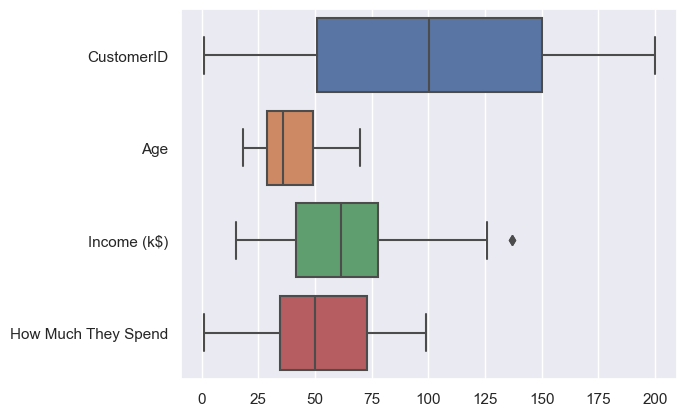

In [60]:
fig = plt.figure()
sns.boxplot(data=df_eda, orient="h")
plt.show()

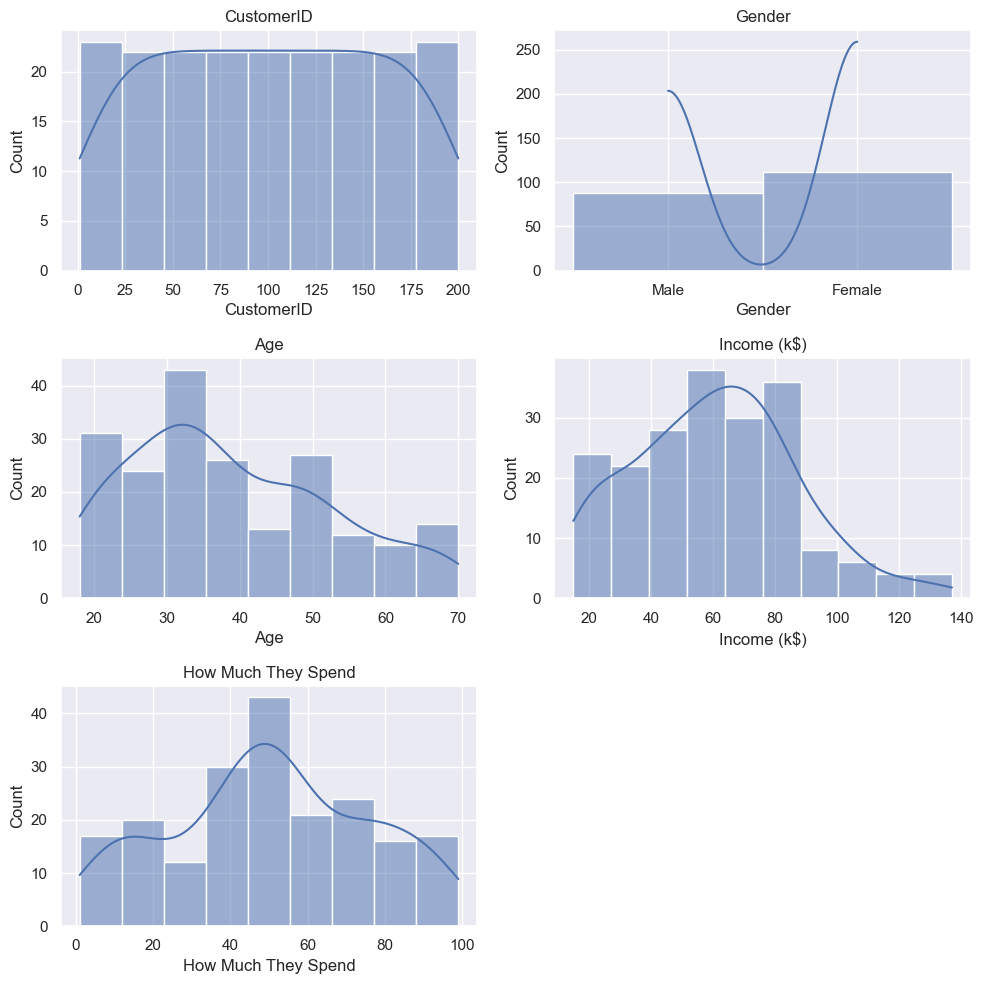

In [61]:
plt.figure(figsize=(10, 10))

columns = df_eda.columns
num_columns = len(columns)
num_rows = (num_columns + 1) // 2

for i, column in enumerate(columns):
    plt.subplot(num_rows, 2, i + 1)
    sns.histplot(data=df_eda[column], kde=True)
    plt.title(column)
    plt.tight_layout()

plt.show()

### Observations:

We can see that How Much They Spend, and CustomerID is relatively normally distributed. With somewhat of a bell curved shape. 

Age and Income are skewed to the left.

<AxesSubplot: ylabel='Gender'>

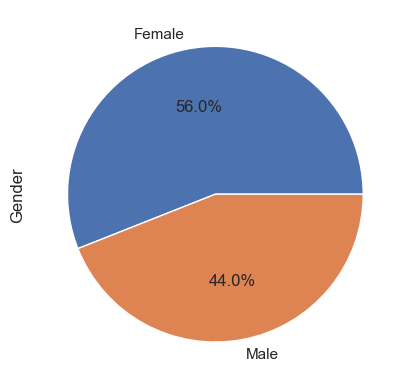

In [62]:
df_eda["Gender"].value_counts().plot.pie(
    autopct="%1.1f%%",
    explode=(0, 0)
    )

### Observations:

We can observe that there are more Females than there are Male customers

# Bivirate Analysis

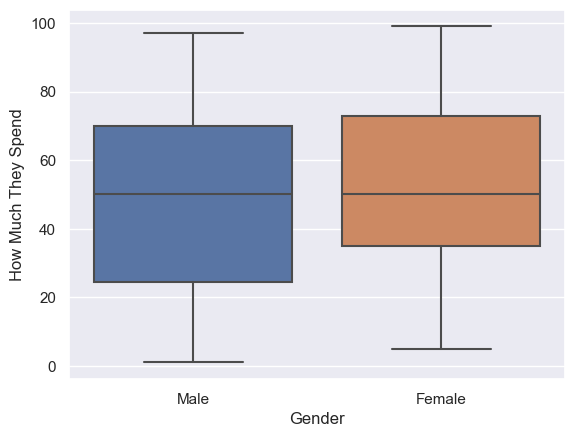

In [63]:
fig, ax = plt.subplots()
sns.boxplot(data=df_eda, x="Gender", y="How Much They Spend")
plt.show()

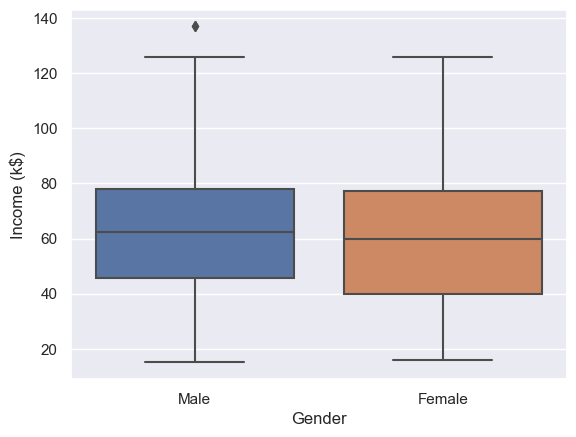

In [64]:
fig, ax = plt.subplots()
sns.boxplot(data=df_eda, x="Gender", y="Income (k$)")
plt.show()

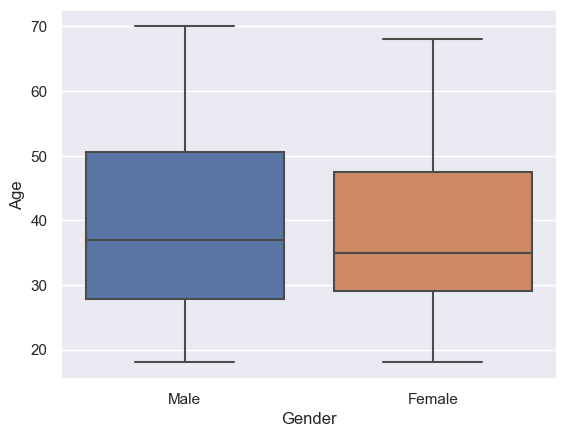

In [65]:
fig, ax = plt.subplots()
sns.boxplot(data=df_eda, x="Gender", y="Age")
plt.show()

### Observations:

We can observe that Males and Females spend about the same amout of money. However we can also observe that Females spend slightly more than Males.

We can observe that the Income of Males and Females is almost identical. However Males have a slightly higher mean Income.

We can observe that the Ages of Males and Females is also almost identical. However Males have a slightly higher mean Age.

Assigning the value of 1 to Male, and 0 to female

In [66]:
df_eda["Gender"] = pd.Series(
    np.where(df_eda["Gender"].values == "Male", 1, 0), df_eda.index
)

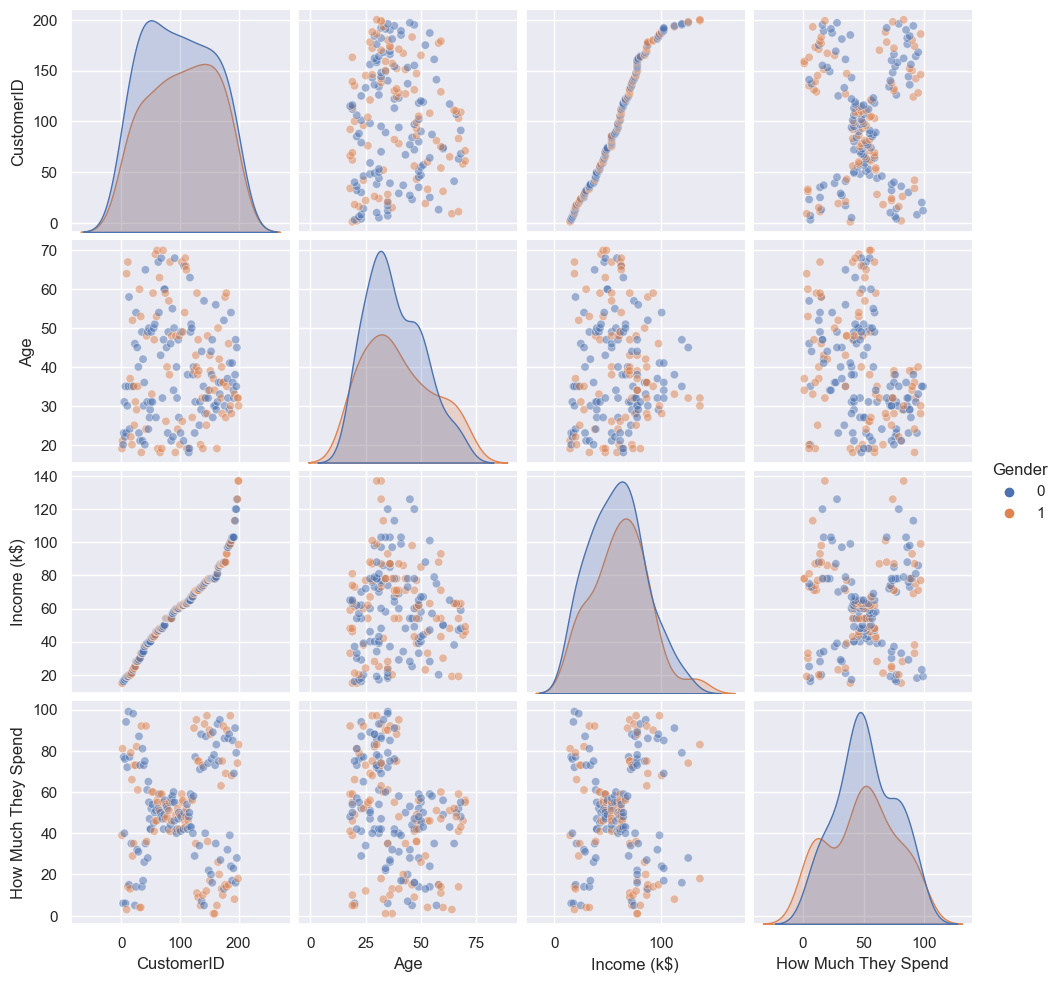

In [67]:
sns.pairplot(data=df_eda, hue="Gender", plot_kws={"alpha": 0.5})
plt.show()

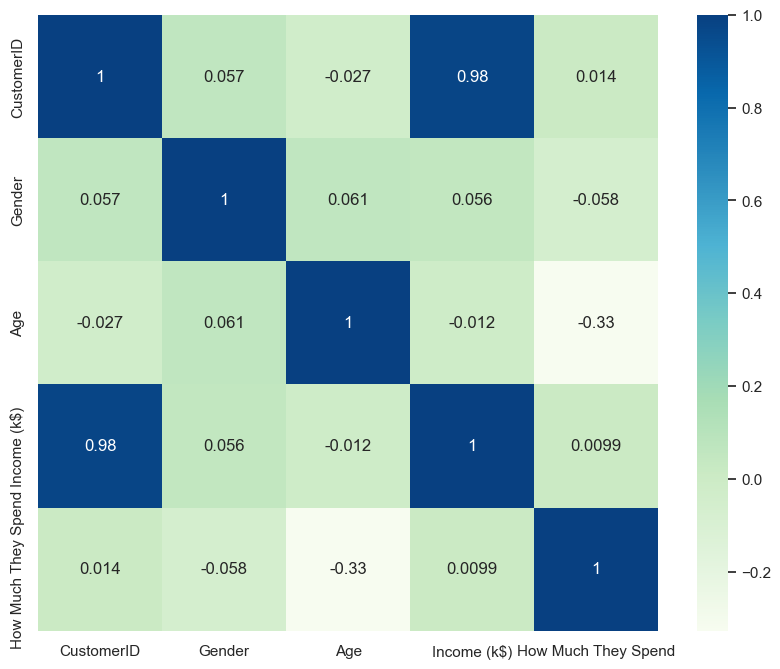

In [68]:
plt.figure(figsize=(10,8))
sns.heatmap(df_eda.corr(), annot=True, cmap="GnBu")
plt.show()

Dropping CustomerID as it is irrelavent, and has close to no correlation.

In [69]:
df = df.drop(columns=["CustomerID"])

# Encoding

##### We have multiple choices of Encoding methods here:

1. One Hot Encoding
    - One Hot encoding has the disadvantage of creating a high-dimentional and sparse representation when dealing with large number of categories. Gender do not have many categories, only having 2, male and female. And thus this is not an issue. Thus I will use this encoding method
2. Label Encoding
    - Label encoding would introduce abitrary ordinal relationships between categories which might mislead the learning algorithm. So we will not use it.
3. Ordinal Encoding
    - It assumes uniform differences between my encoded values. Which is not the case here. Thus I will not use this encoding method.
4. Count Encoding
    - This normally results in overfitting. Even though my correlation of my target variable has a very low correlation to variables. Thus there should be no issues, however, I will use One Hot encoding as it is more suitable for this type of categorical data, and I do not want to show the frequency of my data.
5. Binary Encoding
    - It assumes that the order of my categories matters. In this case, gender, or marriage status does not have an order. Thus I will not use this encoding method.
6. Target Encoding
    - This encoding method generally leads to overfitting when there are a low number of entries in the dataset. The provided dataset has very few values. Thus I will not use this encoding method.

In [70]:
df.head()

,Gender,Age,Income (k$),How Much They Spend
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [71]:
df = pd.get_dummies(df)
df = df.drop(columns = ["Gender_Female"])
df = df.rename(columns = {"Gender_Male":"Gender"})
display(df.head())

,Age,Income (k$),How Much They Spend,Gender
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


# Standardizing

Standardizing is to help the model compute the data with more ease, and to help ensure that the machine algorithm has different features on a similar scale.

1. Z-Score Standardization (Standard Scaler)
    - This is good for preserving the original distribution and shape.
    - Not good at handling outliers.
    - Gives Gaussian Distribution

2. Min-Max Scaling
    - Useful when wanting to preserve the relationships between data points.
    - Cannot handle outliers.
3. Unit Vector Scaling
    - Not as sensitive to outliers
    - Very useful to datasets with a lot of outliers
    - Requires Gaussian distribution
4. Unit Vector Scaling
    - Useful for sparse data
    - Does not maintain original relationships between data points


In order to identify the correct type of scaler to use, I will use the Shapiro Wilk Test, the Anderson Darling Test, a Histogram, and a Probability Plot to see whether there is Gaussian Distribution.

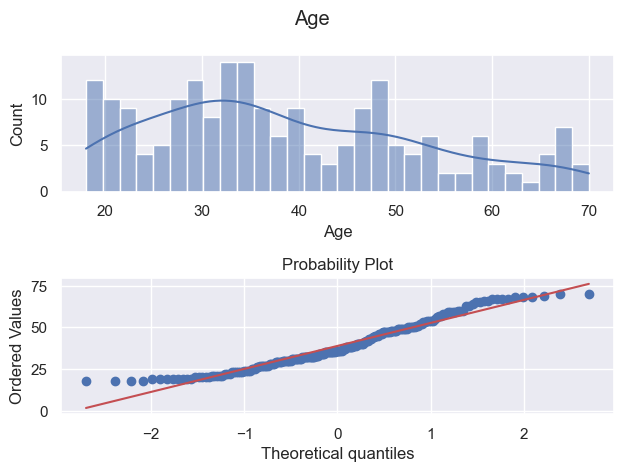

Shapiro-Wilk Test:
Statistic: 0.9516184329986572
p-value: 2.7109526854474097e-06

Anderson-Darling Test:
Statistic: 2.489094012240969
Critical Values: [0.565 0.644 0.772 0.901 1.071]


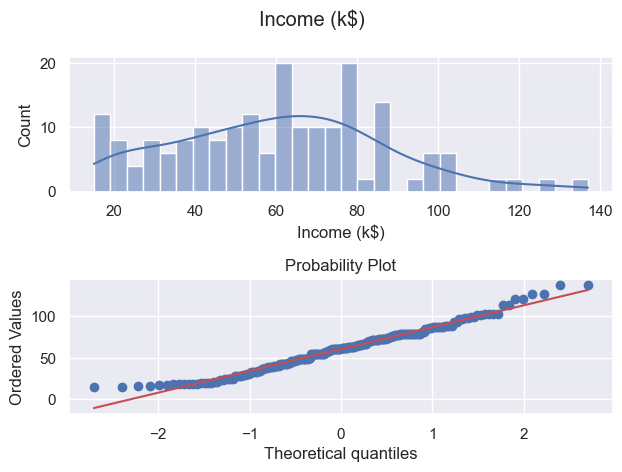

Shapiro-Wilk Test:
Statistic: 0.9783905148506165
p-value: 0.003537340322509408

Anderson-Darling Test:
Statistic: 0.6844419180561658
Critical Values: [0.565 0.644 0.772 0.901 1.071]


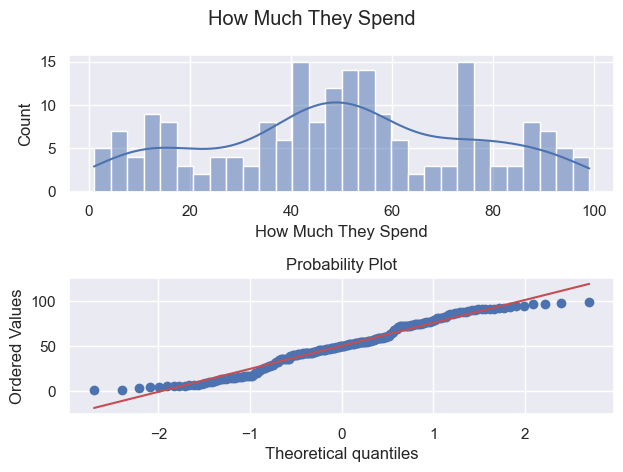

Shapiro-Wilk Test:
Statistic: 0.9694603085517883
p-value: 0.00024227304675150663

Anderson-Darling Test:
Statistic: 1.3506265307220815
Critical Values: [0.565 0.644 0.772 0.901 1.071]


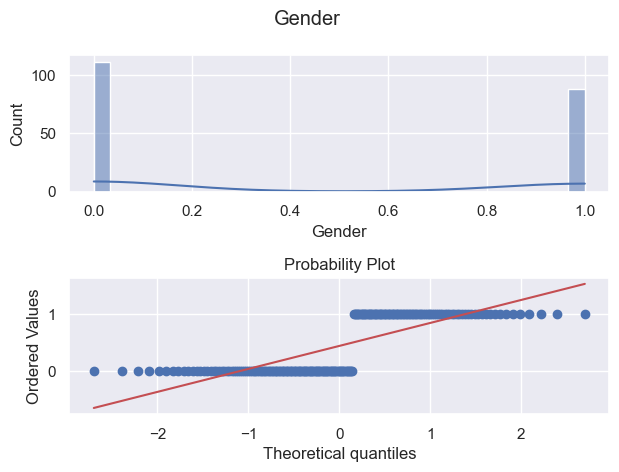

Shapiro-Wilk Test:
Statistic: 0.6311769485473633
p-value: 1.4683150575283815e-20

Anderson-Darling Test:
Statistic: 36.45581771597631
Critical Values: [0.565 0.644 0.772 0.901 1.071]


In [72]:
for i in df.columns:
    fig, ax = plt.subplots(2, 1)
    sns.histplot(data=df[i], bins=30, ax=ax[0], kde=True)
    stats.probplot(df[i], plot=ax[1])
    plt.suptitle(i)
    plt.tight_layout()
    plt.show()

    statistic, p_value = stats.shapiro(df[i])
    print("Shapiro-Wilk Test:")
    print("Statistic:", statistic)
    print("p-value:", p_value)

    result = stats.anderson(df[i])
    print("\nAnderson-Darling Test:")
    print("Statistic:", result.statistic)
    print("Critical Values:", result.critical_values)


From the above tests, we can observe that the histograms have a smooth curve, and are pretty bell shaped. Income and Age are slightly scewed to the left, however the rest are not.

Thus we can assume that they have Gaussian Distribution.

Along with this, I would like to maintain the relationships between datapoints. Age, Income, and Amount They Spend also have differing units.

Standard Scaler also has the wanted outcome of producing Gaussian Distribution which helps with clustering.

Thus I will use Standard Scaler Scaling for this dataset as it is the most suitable in this situation.

In [73]:
num_cols = [
    "Age",
    "Income (k$)",
    "How Much They Spend",
]
scale = StandardScaler()

scaled_df_copy = df.copy()
scaled_df_copy[num_cols] = scale.fit_transform(df[num_cols])

scaled_df_copy.head()

,Age,Income (k$),How Much They Spend,Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


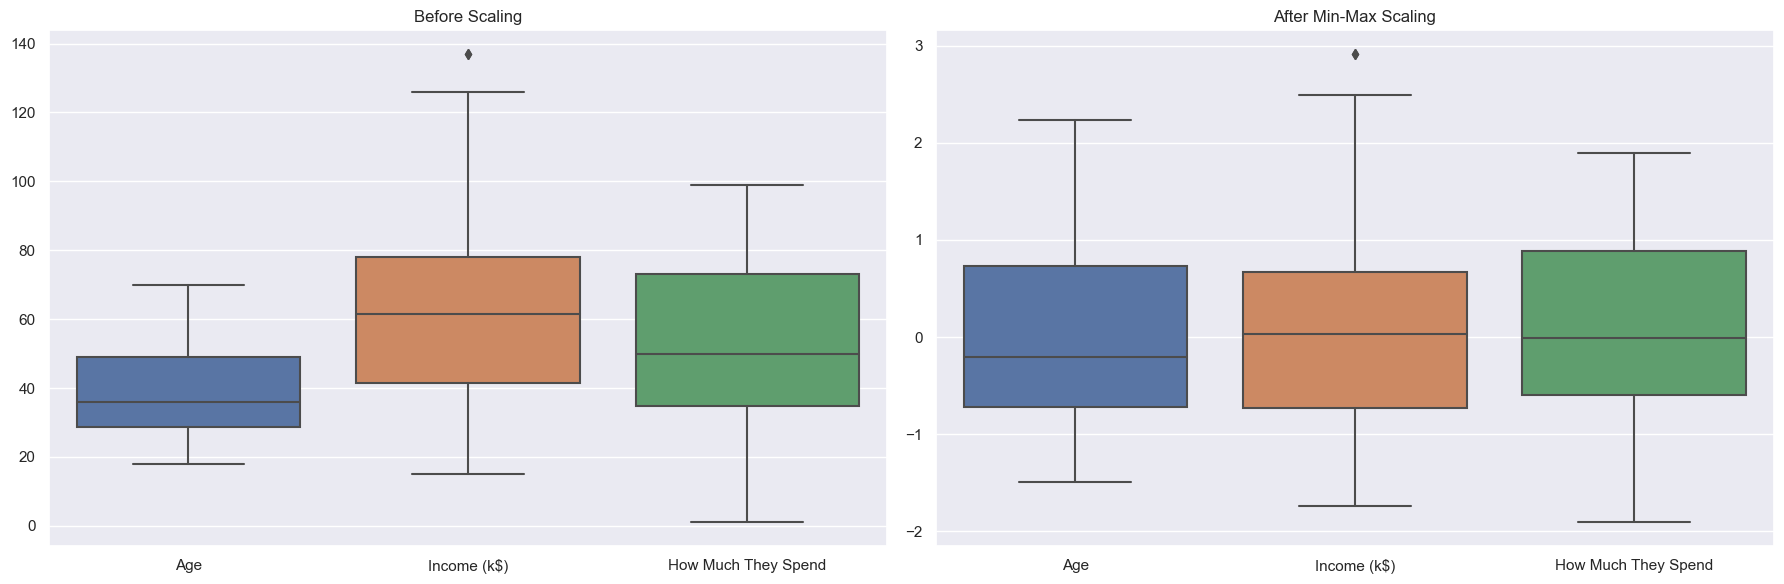

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6), tight_layout=True)
sns.boxplot(df[num_cols], ax=ax[0])
ax[0].set_title('Before Scaling')
sns.boxplot(scaled_df_copy[num_cols], ax=ax[1])
ax[1].set_title('After Min-Max Scaling')
plt.show()

# Hopkins Clustering Tendency Test

This is a test to determine the clustering tendencies of my data.

High Hopkins Statitics:

- Value close to 1. Means that there is a high tendency of clustering. This means that the data is likely to have meaningful clusters.

Low Hopkins Statistics:

- Value close to 0. This means that there is a low tendency of clustering. This means that the data is not likely to perform well.

In [75]:
def hopkins(X):
   d = X.shape[1]
   #d = len(vars) # columns
   n = len(X) # rows
   m = int(0.1 * n) # heuristic from article [1]
   nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

   rand_X = sample(range(0, n, 1), m)

   ujd = []
   wjd = []
   for j in range(0, m):
      u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
      ujd.append(u_dist[0][1])
      w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
      wjd.append(w_dist[0][1])

   H = sum(ujd) / (sum(ujd) + sum(wjd))
   if isnan(H):
      print(ujd, wjd)
      H = 0

   return H

hopkins(scaled_df_copy)

0.6850974066123408

### Observations:

As we can see from the value 0.7 above, the hopkins statistics is above 0.7. However is still very close to 0.5. This would mean that the data is randomly distributed, and somewhat has the tendency to cluster, however it is a moderate tendency.

This means that the data is somewhat able to produce meaningful clusters.

In this case, normal approaches are to apply PCA to help with the weak tendency to cluster. However my dataset is very small. Thus this will not be feasible.

___
# Silouette Coefficient & Inertia
___

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 

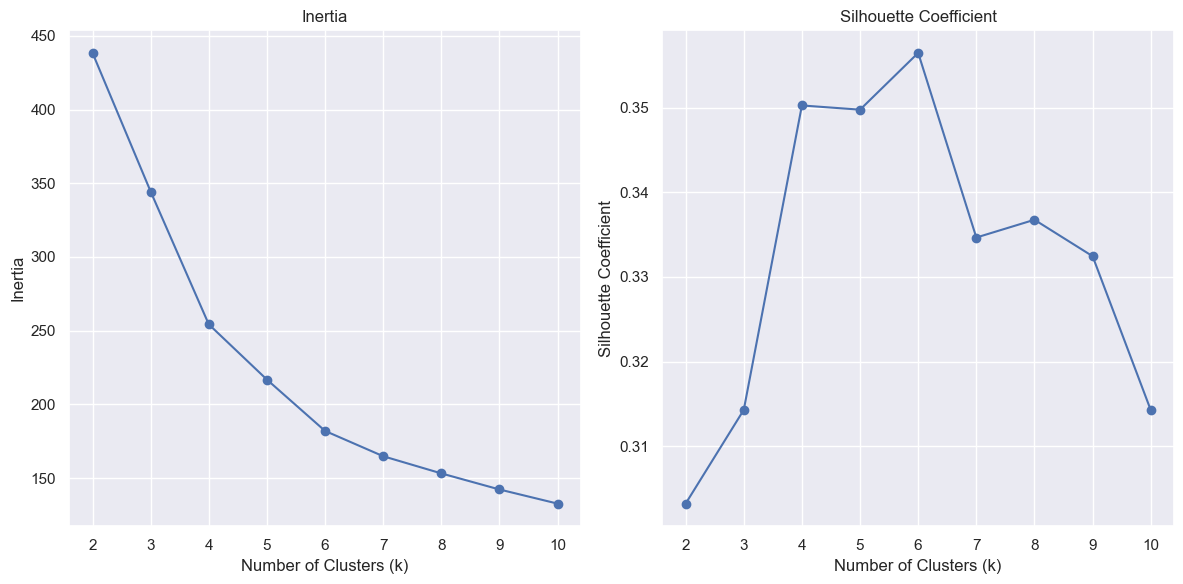

Highest Silhouette Score: 0.3565 (k = 6)


In [76]:
def visualize_kmeans_metrics(data, k_range):
    inertias = []
    silhouette_scores = []

    for k in k_range:
        modelling = KMeans(n_clusters=k, random_state=42)
        modelling.fit(data)
        inertias.append(modelling.inertia_)
        
        silhouette_scores.append(silhouette_score(data, modelling.labels_))

    plt.figure(figsize=(12, 6))
    
    # Plot Inertia
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title(f'Inertia')
    
    # Plot Silhouette Coefficient
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Coefficient')
    plt.title(f'Silhouette Coefficient')

    plt.tight_layout()
    plt.show()

    # Find the index of the highest silhouette score
    best_index = np.argmax(silhouette_scores)
    best_k = k_range[best_index]
    best_score = silhouette_scores[best_index]
    
    print(f"Highest Silhouette Score: {best_score:.4f} (k = {best_k})")

k_range = range(2, 11)  # Range of k values to explore
visualize_kmeans_metrics(scaled_df_copy, k_range)

### Observations:

We can see from the above that The Inertia decreases with the amount of clusters, whilst the Silhouette coefficient increases until its peak at 6. Of which it drops after.

I will use a number of clusters as 6 as it produces the highest Silhouette Score.

In [77]:
best_k = 6

___
# Modelling
___

### For the grading of my models, I will be using the following:

- Silhouette Score:
    - The silhouette score measures the distance between the clusters and the separation between different clusters. It ranges from -1 to 1, with higher values indicating better-defined clusters.

- Davies-Bouldin Index:
    - The Davies-Bouldin index measures the average similarity between each cluster and its most similar cluster. A lower value indicates better clustering.

- Calinski-Harabasz Index (Variance Ratio Criterion):
    - This index measures the ratio of between-cluster variance to within-cluster variance. Higher values indicate better-defined clusters.

In [78]:
def visualize_clusters(model, data, labels, column1, column2, title):
    cluster_labels = model.fit_predict(data)
    
    # Check the number of unique cluster labels
    unique_labels = len(np.unique(cluster_labels))
    if unique_labels < 2:
        print(f"Skipping calculation for {title}: Less than 2 clusters.")
        return None
    
    # Visualize clusters
    plt.scatter(data[:, column1], data[:, column2], c=cluster_labels, cmap='viridis')
    plt.title('Cluster Visualization')
    plt.xlabel(labels[column1])
    plt.ylabel(labels[column2])
    plt.title(title)
    plt.show()

    # Calculate metrics
    silhouette_avg = silhouette_score(data, cluster_labels)
    davies_bouldin = davies_bouldin_score(data, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(data, cluster_labels)

    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Score: {davies_bouldin}')
    print(f'Calinski-Harabasz Score: {calinski_harabasz}')

    return [silhouette_avg, davies_bouldin, calinski_harabasz]


c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


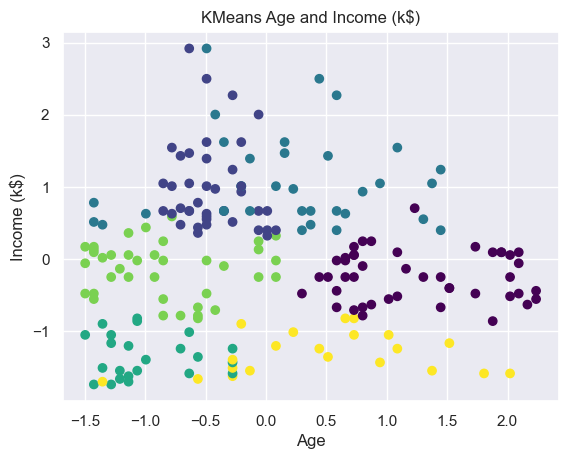

Silhouette Score: 0.356485834425401
Davies-Bouldin Score: 1.0050904211940697
Calinski-Harabasz Score: 99.65487851108833


c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


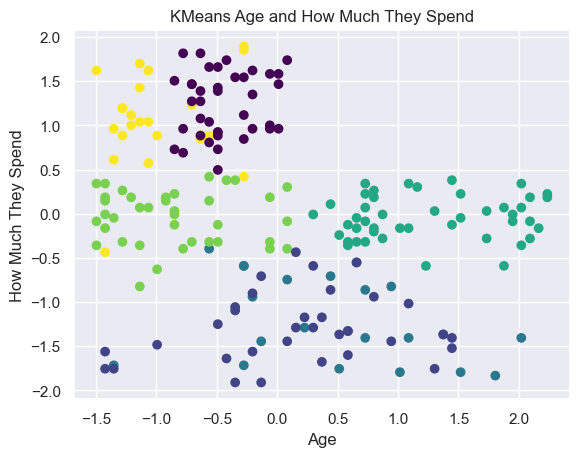

Silhouette Score: 0.356485834425401
Davies-Bouldin Score: 1.0050904211940697
Calinski-Harabasz Score: 99.65487851108833


c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


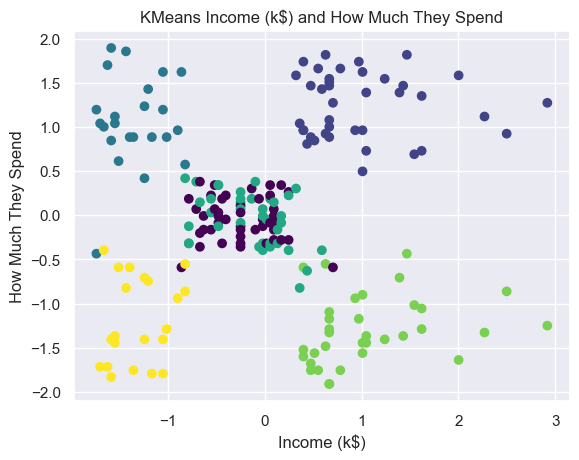

Silhouette Score: 0.356485834425401
Davies-Bouldin Score: 1.0050904211940697
Calinski-Harabasz Score: 99.65487851108833


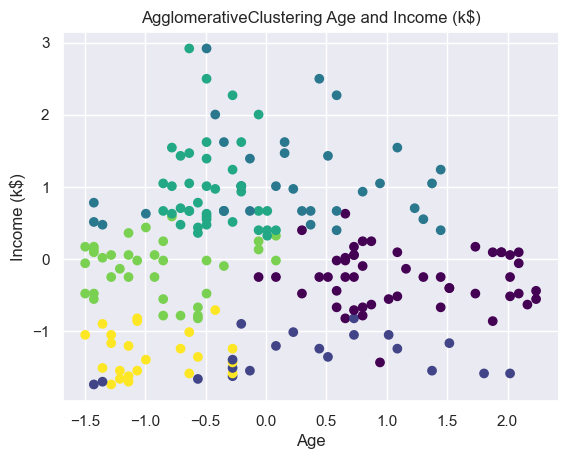

Silhouette Score: 0.3504439354681972
Davies-Bouldin Score: 1.0086149926438526
Calinski-Harabasz Score: 95.2576612909977


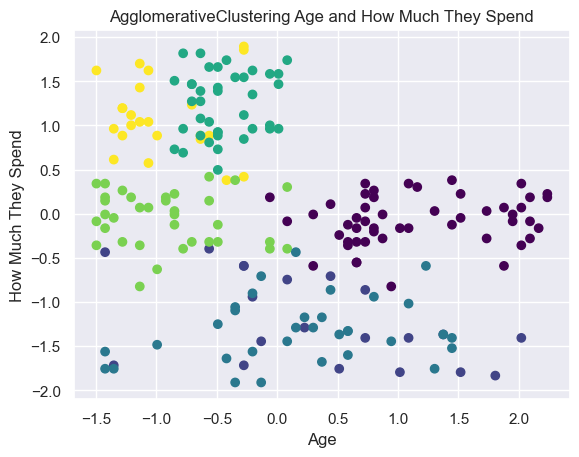

Silhouette Score: 0.3504439354681972
Davies-Bouldin Score: 1.0086149926438526
Calinski-Harabasz Score: 95.2576612909977


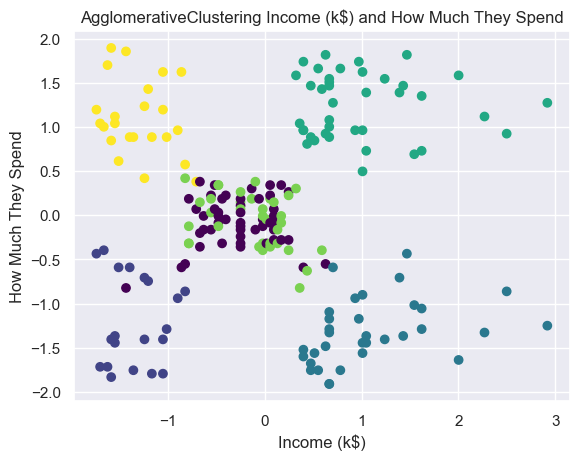

Silhouette Score: 0.3504439354681972
Davies-Bouldin Score: 1.0086149926438526
Calinski-Harabasz Score: 95.2576612909977


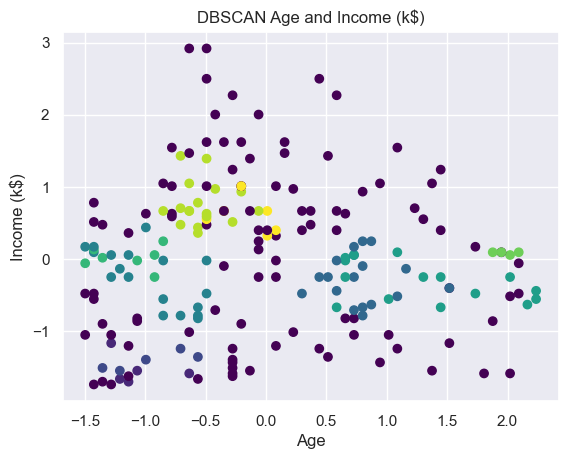

Silhouette Score: -0.011387465358068827
Davies-Bouldin Score: 1.5008184621600702
Calinski-Harabasz Score: 10.8905686733236


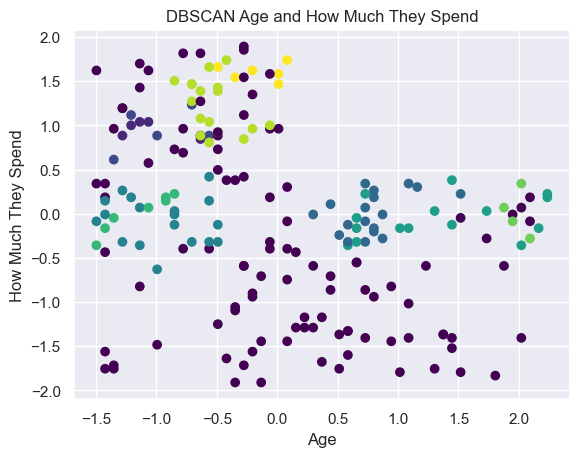

Silhouette Score: -0.011387465358068827
Davies-Bouldin Score: 1.5008184621600702
Calinski-Harabasz Score: 10.8905686733236


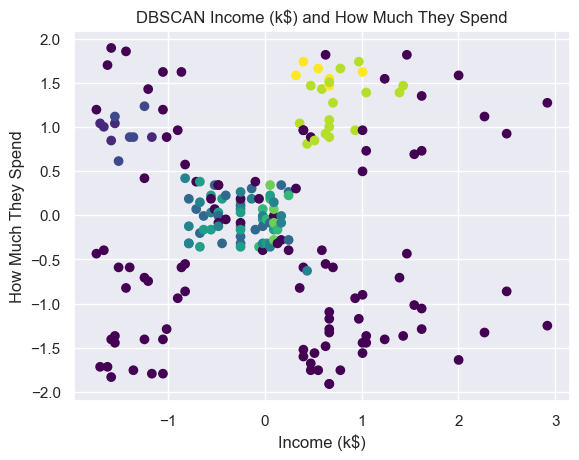

Silhouette Score: -0.011387465358068827
Davies-Bouldin Score: 1.5008184621600702
Calinski-Harabasz Score: 10.8905686733236


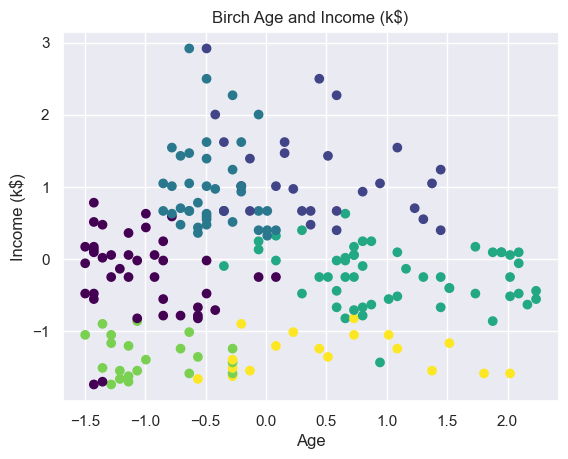

Silhouette Score: 0.3515225000881796
Davies-Bouldin Score: 1.0242115049410312
Calinski-Harabasz Score: 92.61675009985144


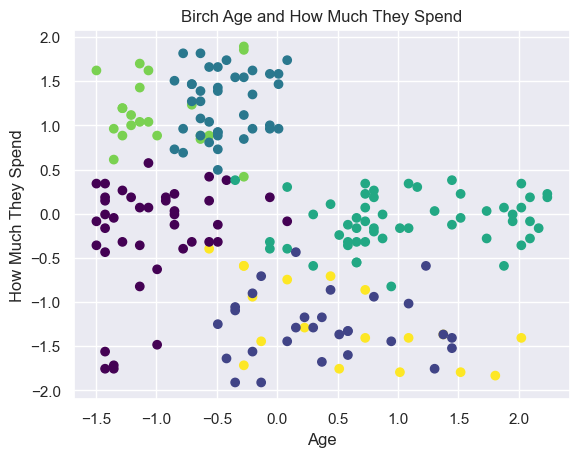

Silhouette Score: 0.3515225000881796
Davies-Bouldin Score: 1.0242115049410312
Calinski-Harabasz Score: 92.61675009985144


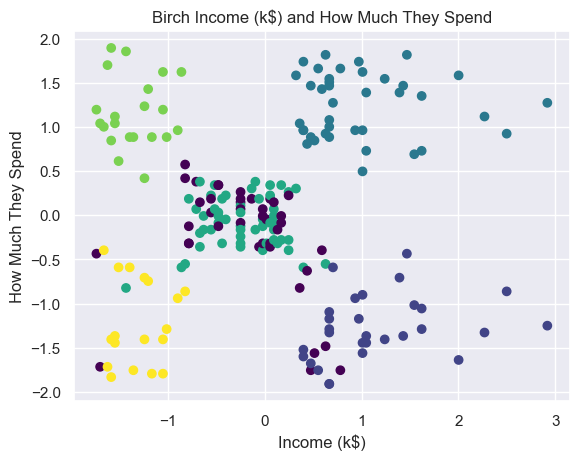

Silhouette Score: 0.3515225000881796
Davies-Bouldin Score: 1.0242115049410312
Calinski-Harabasz Score: 92.61675009985144
Skipping calculation for MeanShift Age and Income (k$): Less than 2 clusters.
Skipping calculation for MeanShift Age and How Much They Spend: Less than 2 clusters.
Skipping calculation for MeanShift Income (k$) and How Much They Spend: Less than 2 clusters.


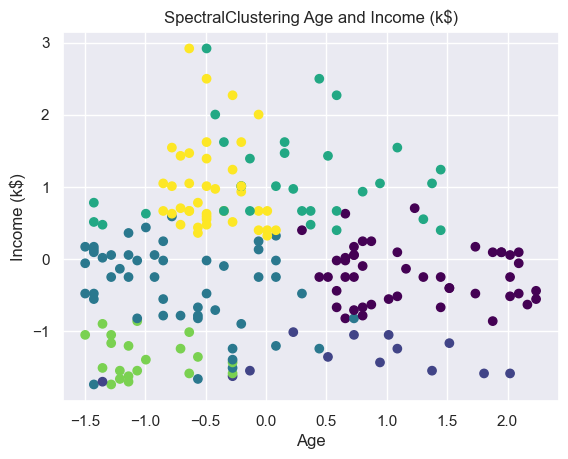

Silhouette Score: 0.34899584272362427
Davies-Bouldin Score: 0.9873092325671254
Calinski-Harabasz Score: 92.76558033313167


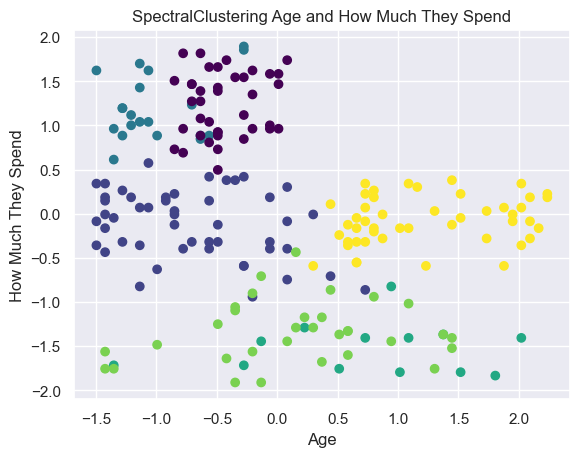

Silhouette Score: 0.34899584272362427
Davies-Bouldin Score: 0.9873092325671253
Calinski-Harabasz Score: 92.7655803331317


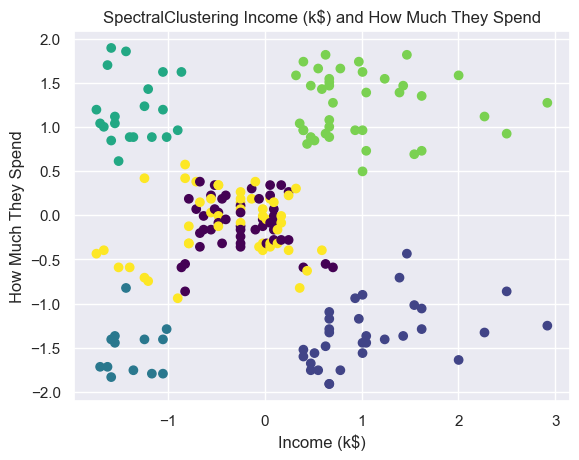

Silhouette Score: 0.3502466214973151
Davies-Bouldin Score: 0.9884297303774822
Calinski-Harabasz Score: 93.84867124497728


In [79]:
models = {
    'KMeans': KMeans(n_clusters=best_k),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=best_k),
    'DBSCAN': DBSCAN(),
    'Birch': Birch(n_clusters=best_k),
    'MeanShift': MeanShift(),
    'SpectralClustering': SpectralClustering(n_clusters=best_k)
}

# Assuming scaled_df_copy is your processed dataset
data = scaled_df_copy.values
feature_labels = scaled_df_copy.columns 

# Visualize clusters and calculate scores
model_names = []
combinations_list = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

numbers = [0, 1, 2]

for model_name, model in models.items():
    for comb in combinations(numbers, 2):
        num1, num2 = comb
        values = visualize_clusters(model, data, feature_labels, num1, num2, model_name + " " + feature_labels[num1] + " and " + feature_labels[num2])
        if values is not None:
            model_names.append(model_name)
            combinations_list.append(", ".join((feature_labels[num1], feature_labels[num2])))
            silhouette_scores.append(values[0])
            davies_bouldin_scores.append(values[1])
            calinski_harabasz_scores.append(values[2])

Since The Graphs are all very hard to compare, we will use the Silhoutee Score, Davies-Bouldin Score, and the Calinski-Harabasz Score in the display below

In [101]:
def highlight_best_worst(s, reverse=False):
    sorted_indices = s.argsort()
    if reverse:
        worst_indices = sorted_indices[-3:]
        best_indices = sorted_indices[:3]
    else:
        worst_indices = sorted_indices[:3]
        best_indices = sorted_indices[-3:]
        
    is_worst = s.index.isin(worst_indices)
    is_best = s.index.isin(best_indices)
    styles = [''] * len(s)
    
    for i, (best, worst) in enumerate(zip(is_best, is_worst)):
        if best:
            styles[i] = 'background-color: green'
        elif worst:
            styles[i] = 'background-color: red'
            
    return styles

# Apply the highlight function for 'Silhouette Score' and 'Calinski-Harabasz Score'
styled_df = results_df.style.apply(highlight_best_worst, subset=['Silhouette Score', 'Calinski-Harabasz Score'], axis=0)

# Apply the reverse highlight function for 'Davies-Bouldin Score'
styled_df_davies = results_df.style.apply(lambda x: highlight_best_worst(x, reverse=True), subset=['Davies-Bouldin Score'], axis=0)

# Combine the styles by chaining them
styled_combined_df = styled_df.apply(lambda x: highlight_best_worst(x, reverse=True), subset=['Davies-Bouldin Score'], axis=0)

# Display the combined styled DataFrame
styled_combined_df

,Model,Combination,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,KMeans,"Age, Income (k$)",0.356486,1.005090,99.654879
1,KMeans,"Age, How Much They Spend",0.356486,1.005090,99.654879
2,KMeans,"Income (k$), How Much They Spend",0.356486,1.005090,99.654879
3,AgglomerativeClustering,"Age, Income (k$)",0.350444,1.008615,95.257661
4,AgglomerativeClustering,"Age, How Much They Spend",0.350444,1.008615,95.257661
5,AgglomerativeClustering,"Income (k$), How Much They Spend",0.350444,1.008615,95.257661
6,DBSCAN,"Age, Income (k$)",-0.011387,1.500818,10.890569
7,DBSCAN,"Age, How Much They Spend",-0.011387,1.500818,10.890569
8,DBSCAN,"Income (k$), How Much They Spend",-0.011387,1.500818,10.890569
9,Birch,"Age, Income (k$)",0.351523,1.024212,92.616750


### Observations:

KMeans has the best silhouette Score and Calinski Harabasz Score.

DBScan has the best Davies Bouldin Score, however has the worst Silhouette Score and Calinski Harabasz Score.

Spectral Clustering has the worst Best Davies Bouldin Score.

Thus I will continue with the best model I have:
KMeans

In [81]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

random_seed = 42

In [82]:
param_grid = {
    'n_clusters': [6],
    'init': ['k-means++', 'random'],
    'max_iter': [100, 300, 500],
    'n_init': [10, 20, 30]
}

# Create an instance of KMeans and GridSearchCV
model = KMeans(random_state=random_seed)
km_grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=silhouette_scorer, n_jobs=-1)

km_grid_search.fit(scaled_df_copy)

print("Best Parameters:", km_grid_search.best_params_)
print("Best Score:", km_grid_search.best_score_)

Best Parameters: {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 6, 'n_init': 20}
Best Score: 0.40487802357769065


In [83]:
km_grid_search.best_estimator_

KMeans(max_iter=100, n_clusters=6, n_init=20, random_state=42)

In [84]:
scaled_df_copy.head()

,Age,Income (k$),How Much They Spend,Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


Now that I have my clusters. I should inverse the scaling on the data so that I can visualize it with values that are easier to understand

In [85]:
properties_to_visualize = ['Age', 'Income (k$)', 'How Much They Spend', 'Gender']

predicted_clusters = km_grid_search.predict(scaled_df_copy[properties_to_visualize])
km_df = scaled_df_copy.copy()
km_df['Cluster'] = predicted_clusters

,Age,Income (k$),How Much They Spend,Gender
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


In [86]:
scaled_data = scaled_df_copy
kmeans_model = km_grid_search.best_estimator_

scaler = StandardScaler()
scaler.fit(df)
original_data = scaler.inverse_transform(scaled_data)

scaled_centroids = kmeans_model.cluster_centers_
original_centroids = scaler.inverse_transform(scaled_centroids)

kmeans_model.fit(original_data)

KMeans(max_iter=100, n_clusters=6, n_init=20, random_state=42)

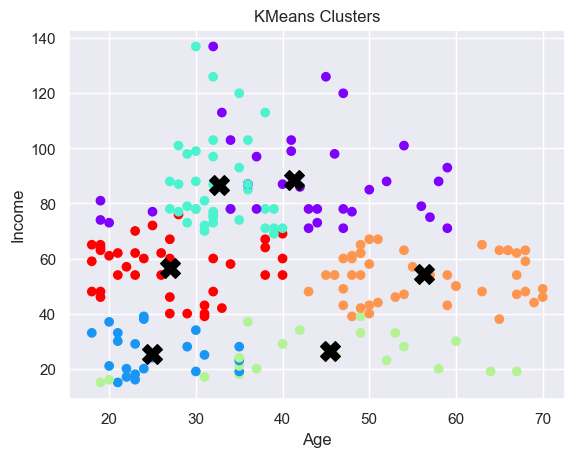

In [87]:
# Visualize the clusters using the original data
plt.scatter(original_data[:, 0], original_data[:, 1], c=kmeans_model.labels_, cmap='rainbow')
plt.scatter(original_centroids[:, 0], original_centroids[:, 1], marker='X', s=200, c='black')
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('KMeans Clusters')
plt.show()

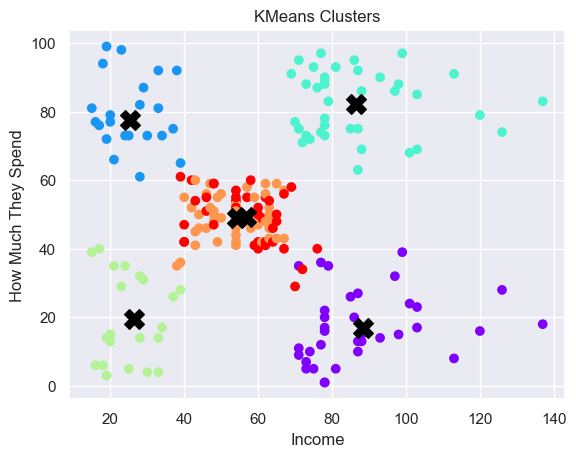

In [88]:
# Visualize the clusters using the original data
plt.scatter(original_data[:, 1], original_data[:, 2], c=kmeans_model.labels_, cmap='rainbow')
plt.scatter(original_centroids[:, 1], original_centroids[:, 2], marker='X', s=200, c='black')
plt.xlabel('Income')
plt.ylabel('How Much They Spend')
plt.title('KMeans Clusters')
plt.show()

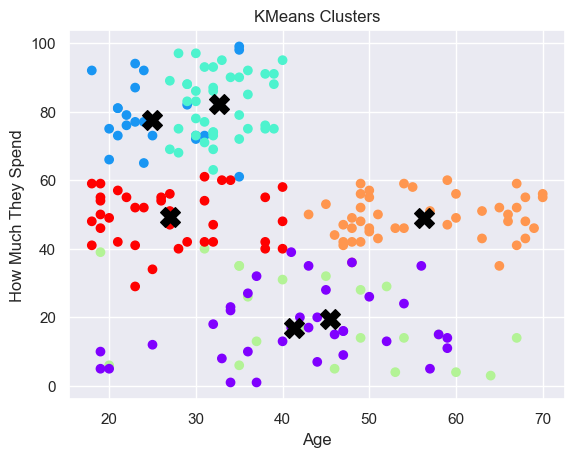

In [89]:
# Visualize the clusters using the original data
plt.scatter(original_data[:, 0], original_data[:, 2], c=kmeans_model.labels_, cmap='rainbow')
plt.scatter(original_centroids[:, 0], original_centroids[:, 2], marker='X', s=200, c='black')
plt.xlabel('Age')
plt.ylabel('How Much They Spend')
plt.title('KMeans Clusters')
plt.show()

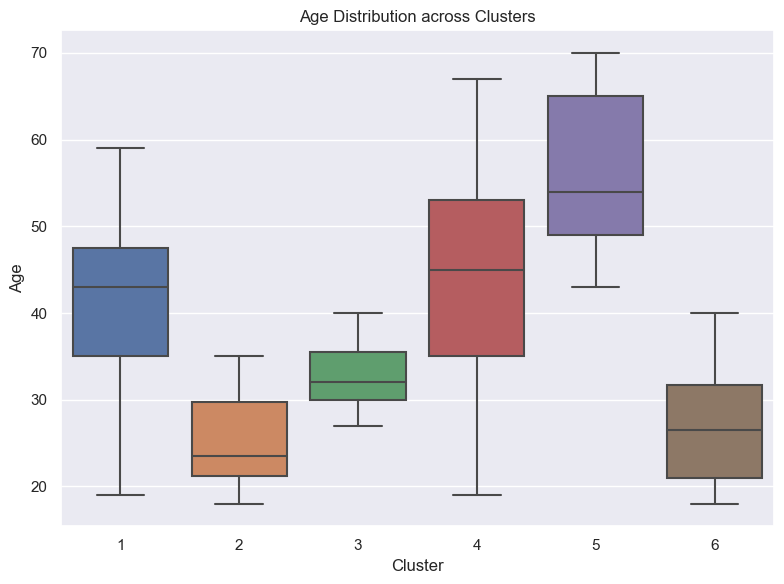

In [90]:
cluster_labels = kmeans_model.labels_

plt.figure(figsize=(8, 6))
sns.boxplot(x=cluster_labels, y=original_data[:, 0])
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.title('Age Distribution across Clusters')
plt.xticks(range(kmeans_model.n_clusters), range(1, kmeans_model.n_clusters + 1))
plt.tight_layout()
plt.show()

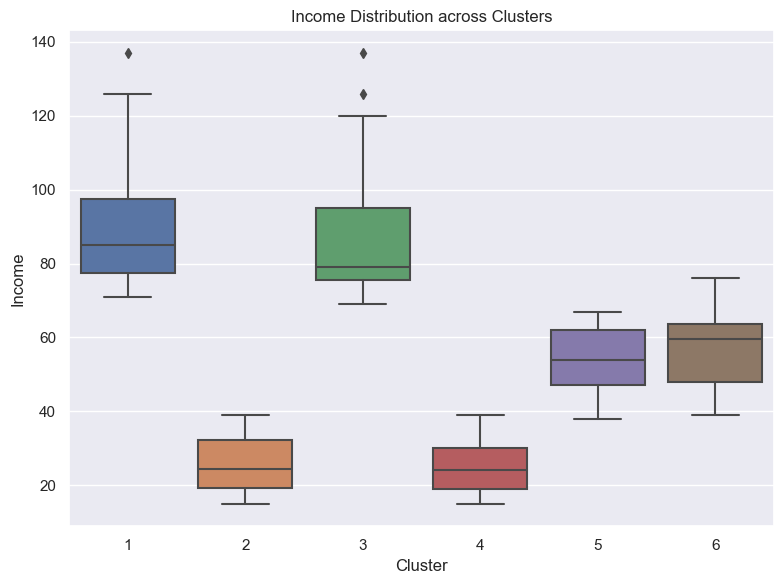

In [91]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=cluster_labels, y=original_data[:, 1])
plt.xlabel('Cluster')
plt.ylabel('Income')
plt.title('Income Distribution across Clusters')
plt.xticks(range(kmeans_model.n_clusters), range(1, kmeans_model.n_clusters + 1))
plt.tight_layout()
plt.show()

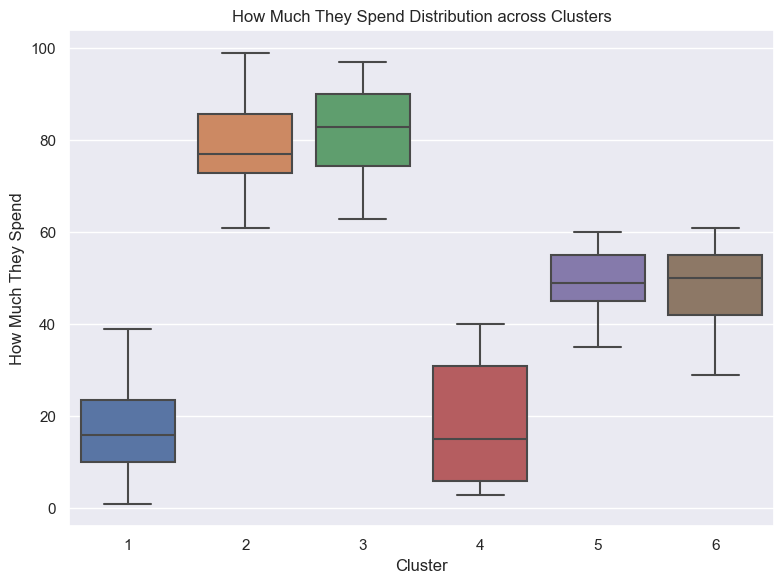

In [92]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=cluster_labels, y=original_data[:, 2])
plt.xlabel('Cluster')
plt.ylabel('How Much They Spend')
plt.title('How Much They Spend Distribution across Clusters')
plt.xticks(range(kmeans_model.n_clusters), range(1, kmeans_model.n_clusters + 1))
plt.tight_layout()
plt.show()

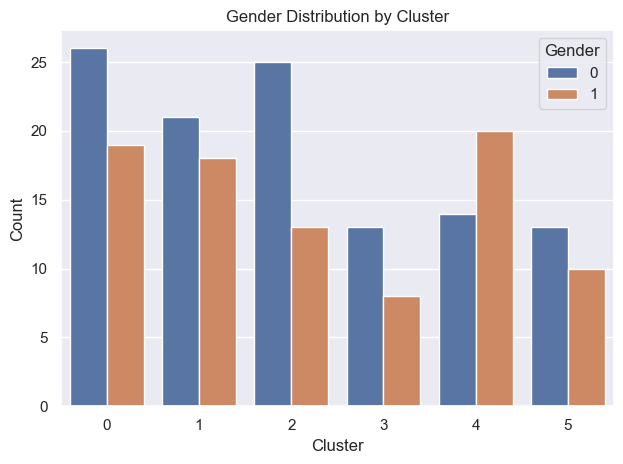

In [102]:
# Create a count of each gender
gender_counts = km_df['Gender'].value_counts()

plt.figure()
ax = sns.countplot(data=km_df, x='Cluster', hue='Gender')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Gender Distribution by Cluster')
plt.tight_layout()

___
# Cluster Interpretation
___

1. Rich But Thrifty. This group has a wide range (20-60). These are people who manage their finances well, that do not spend that much even though they earn a lot. They are untapped potential as they have the resources to spend, however are not willing to spend money on the current products. Eg. Maybe due to pricing, quality, etc. More can be done to target this group.

    - All Ages
    - High Income
    - Low Spending
    - Majority Male


2. Rash Impulsive Youth. This group is made of a small range of youths, 50% of them are between 20 and 30. These young adults do not earn a lot of money, however they still spend a lot. This group would make good long term customers, as they are willing to spend a lot of money despite their income. Their age also allows them to remain as customers for a longer period, making them into potential loyal customers. Due to their income, more budget option products can be made to cater towards them.

    - Young Age
    - Low Income
    - High Spending


3. Earn Big Spend Big. This group is slightly younger than group 1. 50% of them are between 30 and 35. These middle aged adults earn a lot of money, and they spend equal to their pay. Spending what they have earned. This group is potential fufilled. Like the first group, they have the income to spend, however this group has the will to spend it. They are also willing to purchase larger orders. This group are current loyal customers. Not much needs to be done for them.

    - Middle Aged
    - High Income
    - High Spending


4. Money Scrounging. This group is made of a really wide range (20-70). These are people of all ages that do not earn a lot of money, and do not spend a lot because of it. This group does not have the resources nor the will to spend their resources. More budget options should be made to cater towards them, however there is not much potential in specifically advertising to this group.

    - All Ages
    - Low Income
    - Low Spending


5. Old And Average. This group is made out of much older people. 50% between 50 and 65. They earn and spend right in the middle. These are customers that spend a good amount of money at our store, but is not over the top. They are a good source of revenue, and they earn a good source too. They can easily become loyal customers, and more targetted advertising can be done to attract them to spend more. However this group is older, so they should be prioritised less than group 6.

    - Old Age
    - Middle Income
    - Middle Spending


6. Young And Average. This group is made out of much younger people. 50% between 20 and 35. They earn and spend right in the middle. These are customers that spend a good amount of money at our store, but is not over the top. They are a good source of revenue, and they earn a good source too. They can easily become loyal customers, and more targetted advertising can be done to attract them to spend more. This group is younger than group 5. Thus they should be prioritised in campaigns and advertising.

    - Young Age
    - Middle Income
    - Middle Spending